<h1> 1. Introduction </h1>

<h6> 1.1 Background </h6>
<p> In the trucking industry, carriers and brokers often negotiate pricing for the transportation of goods. Dispatchers have the task to get the highest possible rate for a lane (a route, i.e. VA to NC), while brokers want to pay the lowest possible rate. Dispatchers who are new to the company or industry often don't know the market rate for a lane, and brokers can take advantage of this by offering a lower rate than the market rate. This can lead to a loss of revenue for the company. This project aims to solve that problem by introducing a supervised machine learning model which allows dispatchers to see what past rates have looked like for a lane. As this will be a regression model (predicting rates), we will try to first use linear regression. Then we will attempt to achieve higher accuracy using something more complex, like a support vector machine. </p>

<h6> 1.2 Data Sources </h6>
<p> The dataset will comprise of two separate datasets that will be merged. Firstly, we will build a private sampled dataset of past loads hauled by a carrier (in this case, my family's business). This will include the origin, destination, rate, and other relevant information. <b> For the dataset provided in this project, some columns will be removed for confidentiality reasons. However, these columns are going to be dropped anyways, it won't affect the model. </b>

The second dataset will be public and consists of US cities <i>(US cities basic. (n.d.). [Dataset]. Simple Maps. https://simplemaps.com/data/us-cities)</i>. We will use this to retrieve the latitude and longitude of the origin and destination cities. </p>










<h1> 2. Data Preparation </h1>
<h6> 2.1 Data Overview </h6>
<p> The original carrier dataset consists of 1,274 rows and 7 features (for privacy reasons, some columns have been removed in the dataset in this repo). The public dataset consists of 30,844 rows and 17 features.
 The carrier dataset features are:
 <ul>
  <li>
    <strong>InvoiceNumber</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Unique invoice identifier (Not included in provided dataset)</li>
    </ul>
  </li>
  <li>
    <strong>LoadNumber</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Unique load identifier (Not included in provided dataset)</li>
    </ul>
  </li>
  <li>
    <strong>Customer</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Customer ID</li>
    </ul>
  </li>
  <li>
    <strong>TotalRate</strong>
    <ul>
      <li><strong>Category:</strong> Regressional</li>
      <li><strong>Description:</strong> Rate for the load</li>
    </ul>
  </li>
  <li>
    <strong>Pickup</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Pickup location, directly parsed from rate confirmation sheet.</li>
    </ul>
  </li>
  <li>
    <strong>Dropoff</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Dropoff location, directly parsed from rate confirmation sheet</li>
    </ul>
  </li>
  <li>
    <strong>PickupDate</strong>
    <ul>
      <li><strong>Category:</strong> Categorical</li>
      <li><strong>Description:</strong> Date of the pickup</li>
    </ul>
  </li>
</ul>

The public US cities dataset has 13 categorical features and 4 numerical features. We will only be using the latitude, longitude, and population as features for this project, which are all numerical. </p>
</p>

In [35]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from preprocess import process_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

data = pd.read_csv('./ml_data.csv')

print("Loaded data")
print("Shape: ", data.shape)
print("Columns: ", data.columns)
print(data.head())

Loaded data
Shape:  (1274, 5)
Columns:  Index(['Customer', 'TotalRate', 'Pickup', 'Dropoff', 'PickupDate'], dtype='object')
   Customer  TotalRate                                      Pickup  \
0         0        0.0                                         NaN   
1      6269     1300.0                    Epes Transport Warehouse   
2      6270     1800.0                                GREENDALE IN   
3      6271      850.0                           VIRGINIA BEACH VA   
4      6272      800.0    920 BLACK SATCHEL RD, CHARLOTTE NC 28216   

                                   Dropoff  PickupDate  
0                                      NaN         NaN  
1                              TA Services  2023-09-21  
2                               CHESTER VA  2023-09-21  
3                          BROWN SUMMIT NC  2023-09-21  
4    2000 Monticello Ave, NORFOLK VA 23517  2023-09-21  


<h6> 2.2 Data Structuring </h6>
<p> Firstly, the PickupDate provided is in a YYYY-MM-DD format. Instead, we can extract the month and year only. <p>


In [36]:
# Convert PickupDate to datetime and extract year and month
data['PickupDate'] = pd.to_datetime(data['PickupDate'], errors='coerce')
data['PickupYear'] = data['PickupDate'].dt.year
data['PickupMonth'] = data['PickupDate'].dt.month
# We can drop the PickupDate column now
data = data.drop(columns=['PickupDate'])

<h6> 2.3 Feature Engineering </h6>
<p> The pickup and dropoff locations are in unstructured text format, as they have been ripped directly from the rate confirmation sheets. We can use the public US cities dataset to extract the city and state from the pickup and dropoff locations. </p>

In [37]:
# Extract US state abbreviations from Pickup and Dropoff
states = {
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
}


In [38]:
# Extract state from text using state abbreviations
def extract_state(text):
    if not isinstance(text, str):
        return None
    words = text.upper().split()
    for word in words:
        if word in states:
            return word
    return None

In [39]:
# Create Pickup State and Dropoff State columns
data['Pickup State'] = data['Pickup'].apply(extract_state)
data['Dropoff State'] = data['Dropoff'].apply(extract_state)

In [40]:
# Load city data and extract city and state
cities = pd.read_csv('./uscities.csv')
cities['city_only'] = cities['city_ascii'].str.upper()
cities['state_only'] = cities['state_id'].str.upper()

In [41]:
# Create lookup dictionaries for city information
state_to_cities = cities.groupby('state_only')['city_only'].apply(set).to_dict()
lookup = {
    (row['state_only'], row['city_only']): {
        'lat': row['lat'],
        'lng': row['lng'],
        'population': row['population']
    }
    for _, row in cities.iterrows()
}

<p> Now that we have the city and state, we can extract the latitude and longitude of the pickup and dropoff locations. </p>
<p> We can also extract the population of the pickup and dropoff locations. </p>
<p> The code below will look through only the cities that are in the state we extracted above. </p>

In [42]:
# Assign Cities and Their Data
for index, row in data.iterrows():
    try:
        pickup_state = row['Pickup State']
        dropoff_state = row['Dropoff State']

        # Process Pickup City
        if pickup_state in state_to_cities:
            possible_cities = state_to_cities[pickup_state]
            pickup_upper = row['Pickup'].upper()
            for city in possible_cities:
                if city in pickup_upper:
                    data.at[index, 'Pickup City'] = city.title()
                    info = lookup.get((pickup_state, city))
                    if info:
                        data.at[index, 'Pickup Lat'] = info['lat']
                        data.at[index, 'Pickup Lng'] = info['lng']
                        data.at[index, 'Pickup Population'] = info['population']
                    break

        # Process Dropoff City
        if dropoff_state in state_to_cities:
            possible_cities = state_to_cities[dropoff_state]
            dropoff_upper = row['Dropoff'].upper()
            for city in possible_cities:
                if city in dropoff_upper:
                    data.at[index, 'Dropoff City'] = city.title()
                    info = lookup.get((dropoff_state, city))
                    if info:
                        data.at[index, 'Dropoff Lat'] = info['lat']
                        data.at[index, 'Dropoff Lng'] = info['lng']
                        data.at[index, 'Dropoff Population'] = info['population']
                    break

    except Exception as e:
        print(f"Error processing row {index}: {e}")


In [43]:
# Fill missing city names
data['Pickup City'] = data['Pickup City'].fillna('Unknown')
data['Dropoff City'] = data['Dropoff City'].fillna('Unknown')

# Remove rows with unknown Pickup or Dropoff cities
data = data[(data['Pickup City'] != 'Unknown') & (data['Dropoff City'] != 'Unknown')]

<p> Now that we have the lat and long of the pickup and dropoff locations, we can calculate the distance between the two points. For this we will use the Haversine distance, which is the shortest distance "as the crow flies." </p>

In [44]:
def haversine_distance(lat1, lng1, lat2, lng2):
    R = 3959  # Radius of Earth in miles
    lat1, lng1, lat2, lng2 = map(math.radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlng / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    return R * c


# Create a new distance column which is the Haversine distance between the pickup and dropoff locations
data['Distance (miles)'] = data.apply(
        lambda row: haversine_distance(row['Pickup Lat'], row['Pickup Lng'], row['Dropoff Lat'], row['Dropoff Lng']),
        axis=1
    )

# Drop the lat and long columns
data = data.drop(columns=['Pickup Lat', 'Pickup Lng', 'Dropoff Lat', 'Dropoff Lng'])

<h6> 2.4 Encoding </h6>
<p> We will encode the categorical features using Label Encoding. </p>

In [45]:
# Encode categorical columns (states)
state_encoder = LabelEncoder()
data['Pickup State'] = state_encoder.fit_transform(data['Pickup State'])
data['Dropoff State'] = state_encoder.fit_transform(data['Dropoff State'])

<p> We can drop the columns InvoiceNumber, LoadNumber, and Pickup City and Dropoff City. Invoice and load numbers are irrelevant and unique, and the cities have been converted to latitude and longitude. </p>

In [46]:
#data = data.drop(columns=['InvoiceNumber', 'LoadNumber'])    This is commented out as the dataset provided already has these removed.
data = data.drop(columns=['Pickup', 'Dropoff', 'Pickup City', 'Dropoff City'])

<h6> 2.6 Data Analysis </h6>
<p> Now that we've done some pre-processing on our data, we can analyze it with a confusion matrix to see the correlation between the features. </p>

Customer                int64
TotalRate             float64
PickupYear            float64
PickupMonth           float64
Pickup State            int64
Dropoff State           int64
Pickup Population     float64
Dropoff Population    float64
Distance (miles)      float64
dtype: object


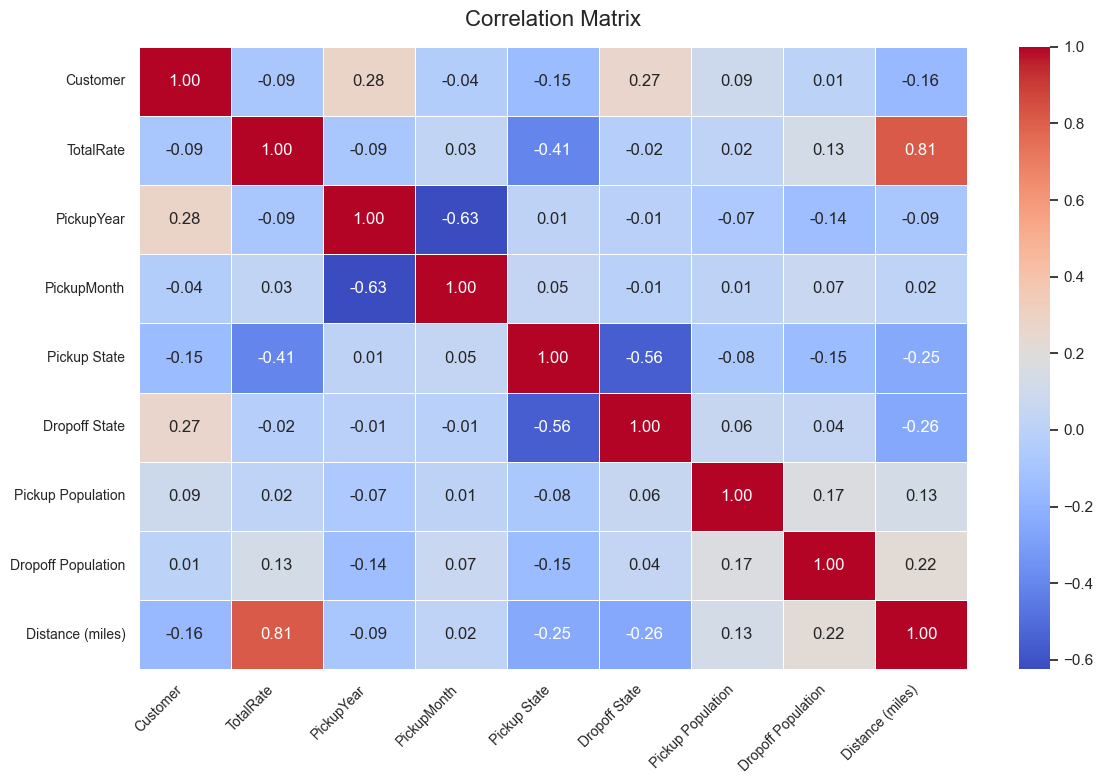

In [47]:


# Correlation Matrix
print(data.dtypes)
corr = data.corr()
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")
heatmap = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Correlation Matrix", fontsize=16, pad=15)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


<h6> 2.7 Analysis of Correlation Matrix </h6>
<p> Looking at the correlation matrix's TotalRate row, The distance feature is the most important. The next best feature is dropoff city population, so we'll keep that feature as well. Interestingly, the pickup state and dropoff state have very low correlation according to this matrix. However, with the knowledge that the states do have a significant factor on the total rate, we know that these should be impactful. As such, we'll try to pair the pickup and dropoff states into one feature and see if that impacts it.</p>

Customer                int64
TotalRate             float64
PickupYear            float64
PickupMonth           float64
Pickup State            int64
Dropoff State           int64
Pickup Population     float64
Dropoff Population    float64
Distance (miles)      float64
Statetostate            int64
dtype: object


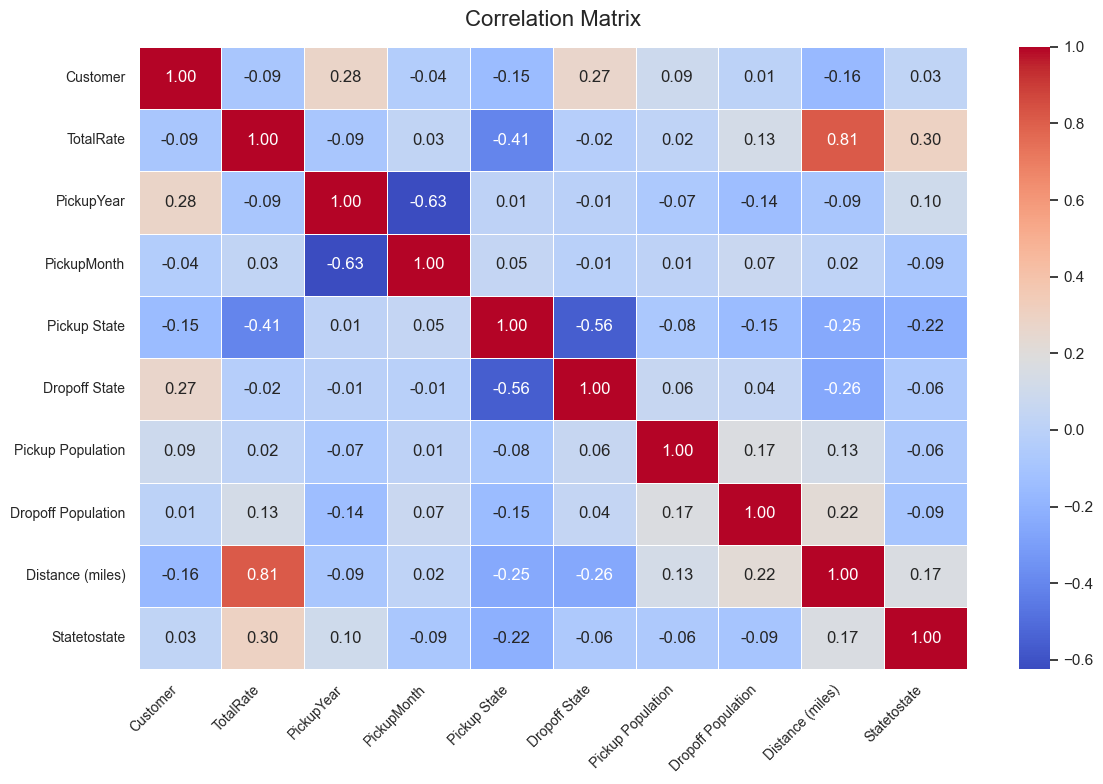

In [48]:
# Create the 'Statetostate' feature
data['Statetostate'] = data['Pickup State'].astype(str) + data['Dropoff State'].astype(str)
statetostate_encoder = LabelEncoder()
data['Statetostate'] = statetostate_encoder.fit_transform(data['Statetostate'])

# Correlation Matrix
print(data.dtypes)
corr = data.corr()
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")
heatmap = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Correlation Matrix", fontsize=16, pad=15)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

data = data[(data['TotalRate'] >= 500) & (data['TotalRate'] <= 2500)]



<p> As seen by the matrix above, Statetostate now gives us a 0.30 rating, significantly higher than pickup state and dropoff state as separate features. We can drop the Pickup State and Dropoff State features now, since they are already represented by Statetostate. </p>
<p> Manually looking at the data point, there are a few outliers that we can remove to help the model. These outliers are TONUs (Truck-Ordered-Not-Used) and rejected shipment rates (truck paid double for return trip but counted same miles), which can result in very low or high rates. </p>
<p> Now that we have an idea of which features to use, we can begin training models. </p>


In [49]:
# Remove outliers before training models
data = data[(data['TotalRate'] >= 500) & (data['TotalRate'] <= 2500)]
data = data.drop(columns=['Customer', 'PickupYear', 'PickupMonth', 'Pickup State', 'Dropoff State', 'Pickup Population']) # We can drop these columns as they have low correlation


<h1> 3. Model Training </h1>
<h6> 3.1 Linear Regression </h6>
<p> We will start by training a linear regression model. In order to further find outliers, we'll get the residuals from the original dataset, then filter out outliers from the training data and train the model again.</p>

Mean Squared Error:  63651.125541444264
R2 Score:  0.6080767981927109
Model Coefficients:  [1.56476859 9.16566486]
Model Intercept:  294.5891481956414


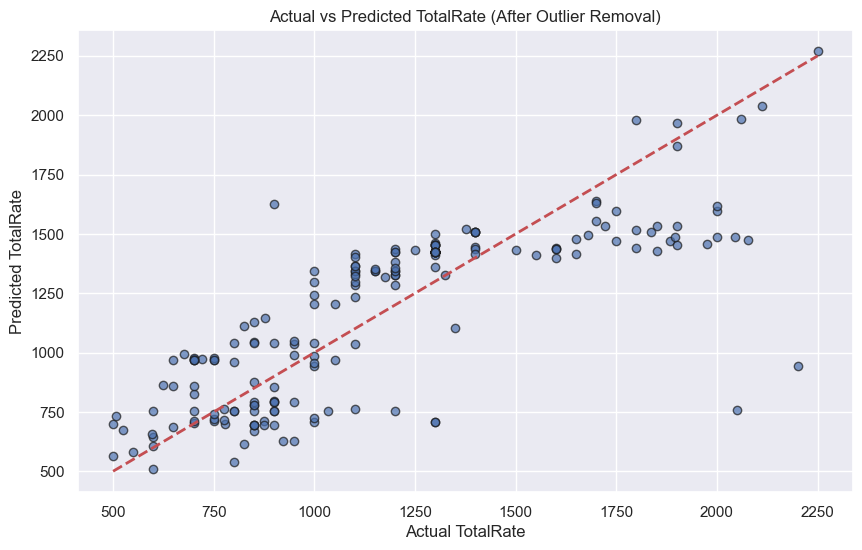

In [50]:
X = data[['Distance (miles)', 'Statetostate']] # Specify features, we will only use distance and statetostate for now
y = data['TotalRate'] # Specify target variable

# Split 80-20 training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Do the initial training on the data without removing more outliers
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred # get the residuals from the training data
threshold = 3 * np.std(residuals) # outliers will be 3 standard deviations away from the mean
non_outliers = np.abs(residuals) <= threshold
X_train_filtered = X_train[non_outliers]
y_train_filtered = y_train[non_outliers]

# Retrain the model
model.fit(X_train_filtered, y_train_filtered)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

print("Model Coefficients: ", model.coef_)
print("Model Intercept: ", model.intercept_)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual TotalRate')
plt.ylabel('Predicted TotalRate')
plt.title('Actual vs Predicted TotalRate (After Outlier Removal)')
plt.grid(True)
plt.show()

<p> We can also try using a regularization model to see if it improves the accuracy. </p>

Mean Squared Error:  63651.141789698086
R2 Score:  0.6080766981462842
Model Coefficients:  [1.56476917 9.16562415]
Model Intercept:  294.5900130548099


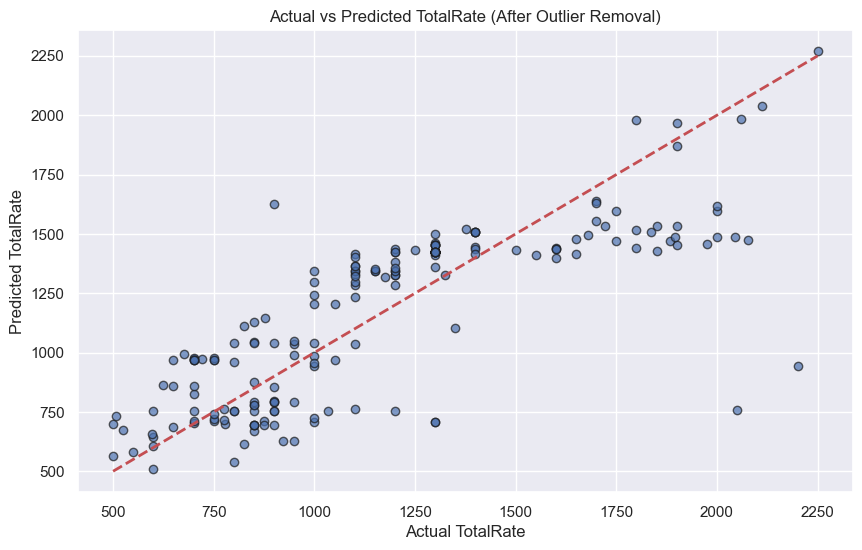

In [51]:
model = LinearRegression()
model = Ridge(alpha=0.5) # Using ridge regression

model.fit(X_train_filtered, y_train_filtered)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

print("Model Coefficients: ", model.coef_)
print("Model Intercept: ", model.intercept_)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual TotalRate')
plt.ylabel('Predicted TotalRate')
plt.title('Actual vs Predicted TotalRate (After Outlier Removal)')
plt.grid(True)
plt.show()




Mean Squared Error:  63652.38563889965
R2 Score:  0.6080690393129566
Model Coefficients:  [1.56481117 9.16221079]
Model Intercept:  294.6654453936487


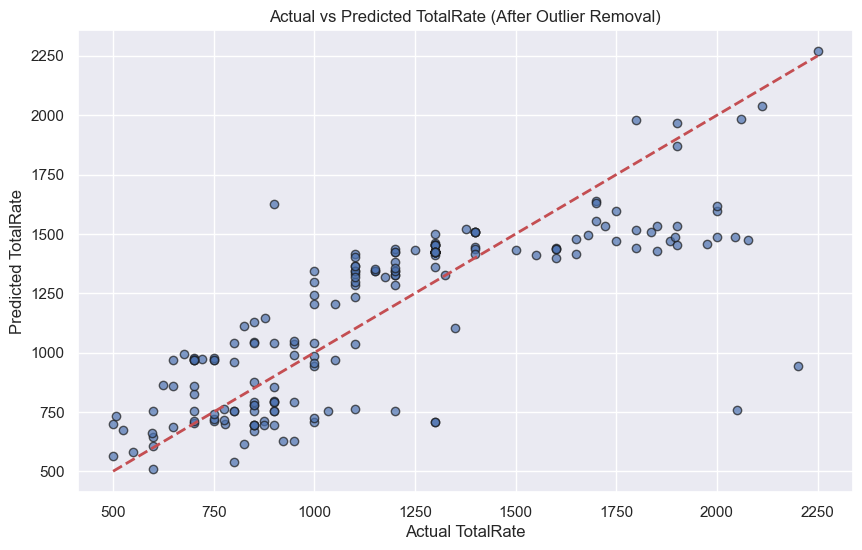

In [52]:
model = LinearRegression()
model = Lasso(alpha=0.5) # Try lasso regression

model.fit(X_train_filtered, y_train_filtered)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

print("Model Coefficients: ", model.coef_)
print("Model Intercept: ", model.intercept_)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual TotalRate')
plt.ylabel('Predicted TotalRate')
plt.title('Actual vs Predicted TotalRate (After Outlier Removal)')
plt.grid(True)
plt.show()


<p> The score we get is around 0.66 - 0.72, which isn't too bad for a simple model like this one. The graph shows a tendency to predict too high when reaching high value loads (> $1500). Since this is a linear model, it can't account for the curve in the data. </p>


<h6> 3.2 Support Vector Machine </h6>
<p> To solve this issue, we'll turn to a support vector regression model. This model can account for the curve in the data, and we can use a radial basis function kernel to help with this. </p>

In [53]:
# we'll redefine the features and target variable
X = data[['Distance (miles)', 'Statetostate']]
y = data['TotalRate']


<p> Because SVMs and SVRs are sensitive to the scale of the data, we can use StandardScaler() to scale the data and then split it. </p>

In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6) # Split 80-20 training and test data

<p> In order to help find the best hyperparameters, we can use GridSearchCV to try different combinations of hyperparameters. </p>

Fitting 5 folds for each of 308 candidates, totalling 1540 fits
Best Hyperparameters:  {'C': 1200, 'epsilon': 100, 'kernel': 'rbf'}
Mean Squared Error:  16118.936843320398
R2 Score:  0.9093258853344441


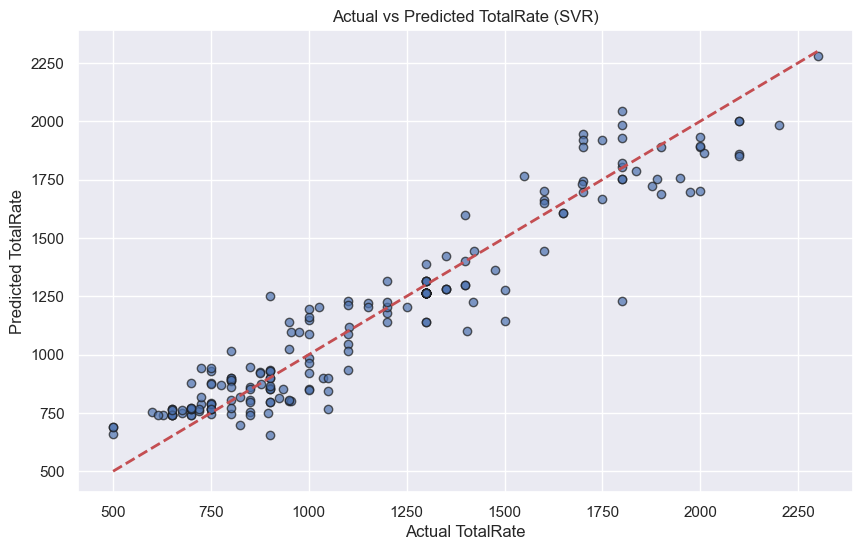

In [55]:
from sklearn.svm import SVR

param_grid = {
    'C': [0.1, 1, 10, 100, 10, 1000, 1200],
    'epsilon': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)

# Get the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual TotalRate')
plt.ylabel('Predicted TotalRate')
plt.title('Actual vs Predicted TotalRate (SVR)')
plt.grid(True)
plt.show()




<h6> 3.3 Final Results </h6>
<p> The hyperparameters C - 1200 and epsilon - 100 using the RBF kernel gave the highest R2 score of ~0.91. This is a significant improvement over the linear regression model which only had a R2 score of ~0.68. </p>
<p> We can also try increasing the C higher but that risks overfitting, and for the purposes of this model a 0.91 R^2 score is good enough. </p>

<h1> 4. Conclusion </h1>
<p> In conclusion, this problem can be partly solved using a linear regression model with mediocre success. While the data may seem linear at first, it is apparent that the data has a curve to it. This is where the support vector regression model shines. By using the radial basis function kernel, we achieved a R2 score of 0.91 which is a significant improvement over the linear regression model, and considerably more than what was needed for the purposes of this model. </p>
<p> A downside to this dataset is the lack of features such as commodity being hauled and elevation data. Loads that travel across mountain ranges can increase fuel consumption and thus have higher rates. Furthermore, more data points would be helpful in improving the model. While 1200 points is a good start, we drop down to below 1000 after removing outliers and null values. A key takeaway is the importance of feature engineering and selection. Without the distance feature, the model would not have been as accurate. Utilizing the correlation matrix was crucial in finding the importance of features which were not obvious to the naked eye. </p>